# DNN 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


## Load data


In [2]:
data = pd.read_csv('creditcard.csv')
print(f"Shape: {data.shape}")
print(f"Fraud rate: {data['Class'].mean()*100:.3f}%")

Shape: (284807, 31)
Fraud rate: 0.173%


In [3]:
train_idx = int(len(data) * 0.70)
val_idx = int(len(data) * 0.85)

train_df = data.iloc[:train_idx].copy()
val_df = data.iloc[train_idx:val_idx].copy()
test_df = data.iloc[val_idx:].copy()

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 199364, Val: 42721, Test: 42722


In [4]:
feat_cols = [f'V{i}' for i in range(1, 29)] + ['Amount']

X_tr = train_df[feat_cols].values
X_v = val_df[feat_cols].values
X_te = test_df[feat_cols].values

y_tr = train_df['Class'].values
y_v = val_df['Class'].values
y_te = test_df['Class'].values


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_v)
X_test = scaler.transform(X_te)

print(f"Features: {X_train.shape[1]}")


Features: 29


## Neural network implementation

In [6]:
class NeuralNet:
    def __init__(self, layer_sizes, learning_rate=0.001, reg_lambda=0.0001):
        self.layer_sizes = layer_sizes
        self.lr = learning_rate
        self.reg = reg_lambda
        self.weights = []
        self.biases = []
        
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        a = X
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            a = self.relu(z)
            self.activations.append(a)
        
        z_out = np.dot(a, self.weights[-1]) + self.biases[-1]
        self.z_values.append(z_out)
        a_out = self.sigmoid(z_out)
        self.activations.append(a_out)
        
        return a_out
    
    def backward(self, X, y, output, pos_weight=1.0):
        m = X.shape[0]
        y_reshaped = y.reshape(-1, 1)
        
        sample_weights = y_reshaped * pos_weight + (1 - y_reshaped)
        dA = (output - y_reshaped) * sample_weights
        
        dW = []
        db = []
        
        for i in reversed(range(len(self.weights))):
            if i == len(self.weights) - 1:
                dZ = dA * self.sigmoid_derivative(self.z_values[i])
            else:
                dZ = dA * self.relu_derivative(self.z_values[i])
            
            dW_i = np.dot(self.activations[i].T, dZ) / m
            db_i = np.sum(dZ, axis=0, keepdims=True) / m
            
            dW.insert(0, dW_i)
            db.insert(0, db_i)
            
            if i > 0:
                dA = np.dot(dZ, self.weights[i].T)
        
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * (dW[i] + self.reg * self.weights[i])
            self.biases[i] -= self.lr * db[i]
    
    def compute_loss(self, y_true, y_pred, pos_weight=1.0):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        y_true_reshaped = y_true.reshape(-1, 1)
        
        pos_term = y_true_reshaped * np.log(y_pred) * pos_weight
        neg_term = (1 - y_true_reshaped) * np.log(1 - y_pred)
        cross_entropy = -np.mean(pos_term + neg_term)
        
        l2_reg = 0
        for w in self.weights:
            l2_reg += np.sum(w ** 2)
        l2_reg = self.reg * l2_reg / (2 * m)
        
        return cross_entropy + l2_reg
    
    def predict(self, X):
        return self.forward(X)
    
    def predict_classes(self, X, threshold=0.5):
        probs = self.predict(X)
        return (probs >= threshold).astype(int).flatten()


In [7]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=256, pos_weight=1.0, verbose=True):
    train_losses = []
    val_losses = []
    n_samples = X_train.shape[0]
    
    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        epoch_loss = 0
        n_batches = 0
        
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            output = model.forward(X_batch)
            loss = model.compute_loss(y_batch, output, pos_weight)
            epoch_loss += loss
            n_batches += 1
            
            model.backward(X_batch, y_batch, output, pos_weight)
        
        avg_train_loss = epoch_loss / n_batches
        
        val_output = model.predict(X_val)
        val_loss = model.compute_loss(y_val, val_output, pos_weight)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses


## Hyperparameter tuning


In [8]:
input_dim = X_train.shape[1]
pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()
print(f"Input dimension: {input_dim}")
print(f"Class imbalance weight: {pos_weight:.2f}")


Input dimension: 29
Class imbalance weight: 518.18


In [10]:
# Define hyperparameter search space
layer_configs = [
    [input_dim, 64, 32, 1],
    [input_dim, 128, 64, 1],
    [input_dim, 128, 64, 32, 1],
    [input_dim, 256, 128, 64, 1],
    [input_dim, 128, 64, 32, 16, 1],
    [input_dim, 64, 32, 16, 1],
]

learning_rates = [0.0001, 0.0005, 0.001, 0.002]
reg_lambdas = [0.0, 0.0001, 0.001, 0.01]
batch_sizes = [128, 256, 512]
epochs_list = [30, 50, 70]

print(f"Total combinations: {len(layer_configs) * len(learning_rates) * len(reg_lambdas) * len(batch_sizes) * len(epochs_list)}")


Total combinations: 864


In [11]:
# We'll do a reduced grid search to keep it manageable
# Focusing on most promising combinations

search_space = [
    {'layers': [input_dim, 64, 32, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.0005, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.002, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.001, 'reg': 0.0, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.001, 'reg': 0.001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 128, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 512, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 30},
    {'layers': [input_dim, 128, 64, 32, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 70},
    {'layers': [input_dim, 256, 128, 64, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 128, 64, 32, 16, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
    {'layers': [input_dim, 64, 32, 16, 1], 'lr': 0.001, 'reg': 0.0001, 'batch': 256, 'epochs': 50},
]

print(f"Testing {len(search_space)} configurations")


Testing 14 configurations


In [14]:
results = []

for idx, config in enumerate(search_space):
    print(f"Configuration {idx+1}/{len(search_space)}")
    print(f"Layers: {config['layers']}, LR: {config['lr']}, Reg: {config['reg']}, Batch: {config['batch']}, Epochs: {config['epochs']}")
 
    
    np.random.seed(42)  # Reset seed for fair comparison
    model = NeuralNet(config['layers'], learning_rate=config['lr'], reg_lambda=config['reg'])
    
    train_losses, val_losses = train_model(
        model, X_train, y_tr, X_val, y_v,
        epochs=config['epochs'], 
        batch_size=config['batch'], 
        pos_weight=pos_weight, 
        verbose=False
    )
    
    # Evaluate on validation set
    val_pred_proba = model.predict(X_val).flatten()
    val_pred = model.predict_classes(X_val)
    
    val_acc = accuracy_score(y_v, val_pred)
    val_prec = precision_score(y_v, val_pred, zero_division=0)
    val_rec = recall_score(y_v, val_pred)
    val_f1 = f1_score(y_v, val_pred)
    val_roc = roc_auc_score(y_v, val_pred_proba)
    val_pr = average_precision_score(y_v, val_pred_proba)
    
    result = {
        'config_id': idx + 1,
        'layers': str(config['layers']),
        'learning_rate': config['lr'],
        'reg_lambda': config['reg'],
        'batch_size': config['batch'],
        'epochs': config['epochs'],
        'val_acc': val_acc,
        'val_prec': val_prec,
        'val_rec': val_rec,
        'val_f1': val_f1,
        'val_roc_auc': val_roc,
        'val_pr_auc': val_pr,
        'final_val_loss': val_losses[-1],
        'final_train_loss': train_losses[-1],
    }
    
    results.append(result)
    
    print(f"Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc:.4f}, PR-AUC: {val_pr:.4f}")

Configuration 1/14
Layers: [29, 64, 32, 1], LR: 0.001, Reg: 0.0001, Batch: 256, Epochs: 50
Accuracy: 0.9778, F1: 0.0955, ROC-AUC: 0.9724, PR-AUC: 0.6608
Configuration 2/14
Layers: [29, 128, 64, 1], LR: 0.001, Reg: 0.0001, Batch: 256, Epochs: 50
Accuracy: 0.9851, F1: 0.1382, ROC-AUC: 0.9659, PR-AUC: 0.7961
Configuration 3/14
Layers: [29, 128, 64, 32, 1], LR: 0.001, Reg: 0.0001, Batch: 256, Epochs: 50
Accuracy: 0.9819, F1: 0.1164, ROC-AUC: 0.9668, PR-AUC: 0.8354
Configuration 4/14
Layers: [29, 128, 64, 32, 1], LR: 0.0005, Reg: 0.0001, Batch: 256, Epochs: 50
Accuracy: 0.9799, F1: 0.1061, ROC-AUC: 0.9605, PR-AUC: 0.8002
Configuration 5/14
Layers: [29, 128, 64, 32, 1], LR: 0.002, Reg: 0.0001, Batch: 256, Epochs: 50
Accuracy: 0.9874, F1: 0.1596, ROC-AUC: 0.9660, PR-AUC: 0.8406
Configuration 6/14
Layers: [29, 128, 64, 32, 1], LR: 0.001, Reg: 0.0, Batch: 256, Epochs: 50
Accuracy: 0.9819, F1: 0.1163, ROC-AUC: 0.9666, PR-AUC: 0.8359
Configuration 7/14
Layers: [29, 128, 64, 32, 1], LR: 0.001, Reg

## Results analysis


In [15]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_pr_auc', ascending=False)

print("Top 5 configurations by PR-AUC (most important for imbalanced data):")
print(results_df[['config_id', 'layers', 'learning_rate', 'reg_lambda', 'batch_size', 'epochs', 'val_f1', 'val_roc_auc', 'val_pr_auc']].head().to_string(index=False))


Top 5 configurations by PR-AUC (most important for imbalanced data):
 config_id               layers  learning_rate  reg_lambda  batch_size  epochs   val_f1  val_roc_auc  val_pr_auc
         8 [29, 128, 64, 32, 1]          0.001      0.0001         128      50 0.159375     0.965884    0.840851
         5 [29, 128, 64, 32, 1]          0.002      0.0001         256      50 0.159624     0.965971    0.840566
        11 [29, 128, 64, 32, 1]          0.001      0.0001         256      70 0.138399     0.966102    0.838140
         6 [29, 128, 64, 32, 1]          0.001      0.0000         256      50 0.116306     0.966620    0.835905
         3 [29, 128, 64, 32, 1]          0.001      0.0001         256      50 0.116438     0.966775    0.835446


In [16]:
print("\nTop 5 configurations by F1 score:")
print(results_df[['config_id', 'layers', 'learning_rate', 'reg_lambda', 'batch_size', 'epochs', 'val_f1', 'val_roc_auc', 'val_pr_auc']].head().to_string(index=False))


Top 5 configurations by F1 score:
 config_id               layers  learning_rate  reg_lambda  batch_size  epochs   val_f1  val_roc_auc  val_pr_auc
         8 [29, 128, 64, 32, 1]          0.001      0.0001         128      50 0.159375     0.965884    0.840851
         5 [29, 128, 64, 32, 1]          0.002      0.0001         256      50 0.159624     0.965971    0.840566
        11 [29, 128, 64, 32, 1]          0.001      0.0001         256      70 0.138399     0.966102    0.838140
         6 [29, 128, 64, 32, 1]          0.001      0.0000         256      50 0.116306     0.966620    0.835905
         3 [29, 128, 64, 32, 1]          0.001      0.0001         256      50 0.116438     0.966775    0.835446


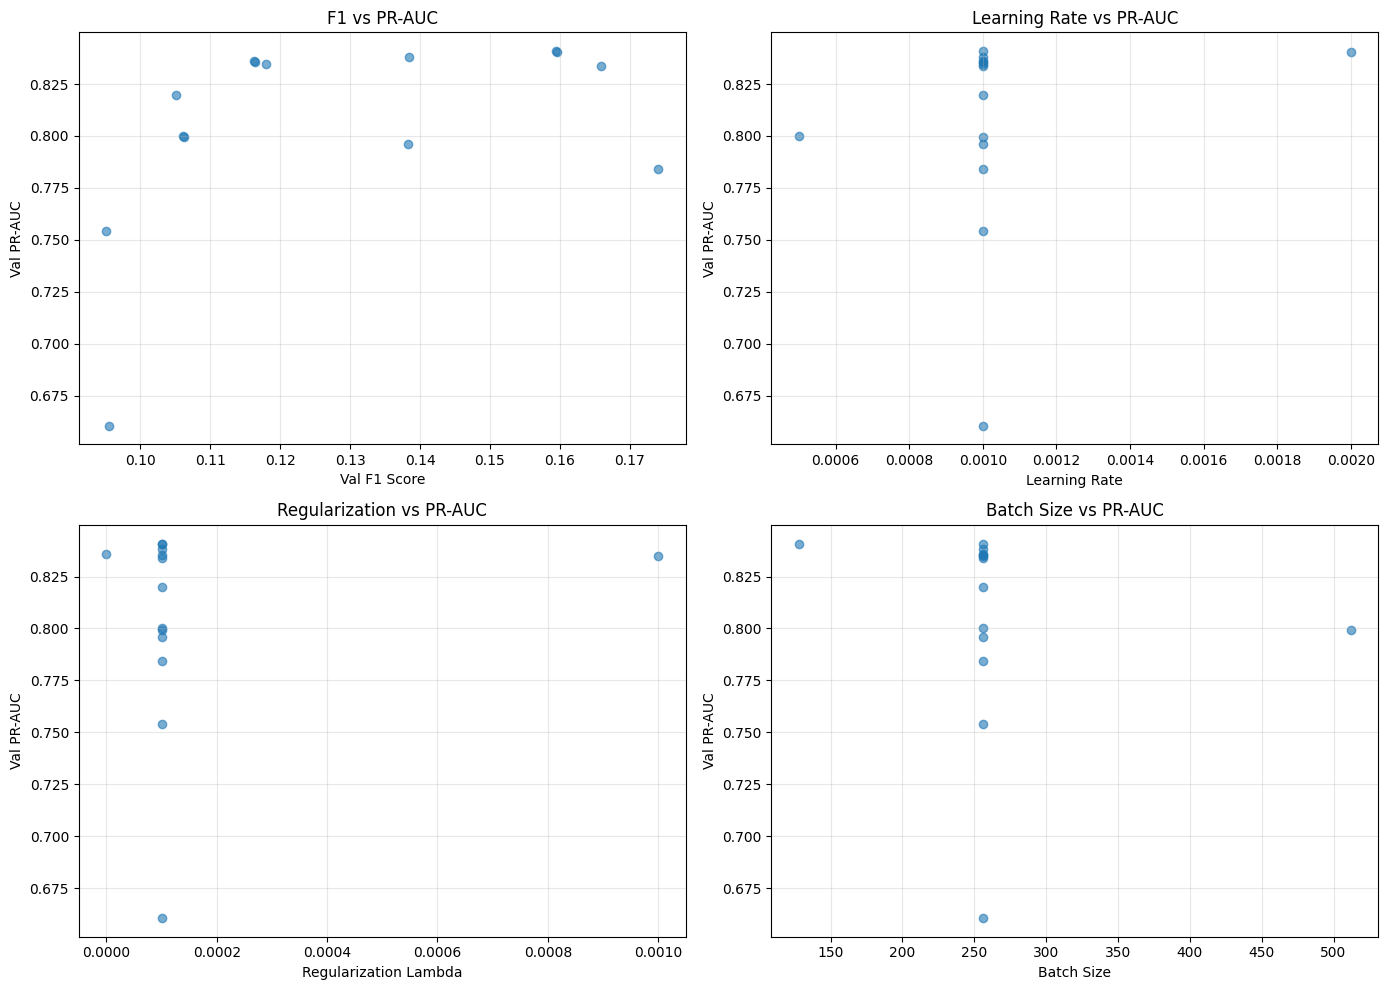

In [17]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(results_df['val_f1'], results_df['val_pr_auc'], alpha=0.6)
axes[0, 0].set_xlabel('Val F1 Score')
axes[0, 0].set_ylabel('Val PR-AUC')
axes[0, 0].set_title('F1 vs PR-AUC')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(results_df['learning_rate'], results_df['val_pr_auc'], alpha=0.6)
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('Val PR-AUC')
axes[0, 1].set_title('Learning Rate vs PR-AUC')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(results_df['reg_lambda'], results_df['val_pr_auc'], alpha=0.6)
axes[1, 0].set_xlabel('Regularization Lambda')
axes[1, 0].set_ylabel('Val PR-AUC')
axes[1, 0].set_title('Regularization vs PR-AUC')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(results_df['batch_size'], results_df['val_pr_auc'], alpha=0.6)
axes[1, 1].set_xlabel('Batch Size')
axes[1, 1].set_ylabel('Val PR-AUC')
axes[1, 1].set_title('Batch Size vs PR-AUC')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Train best model on full training data


In [18]:
best_config_idx = results_df.iloc[0]['config_id'] - 1
best_config = search_space[best_config_idx]

print(f"Best configuration (by PR-AUC):")
print(f"  Layers: {best_config['layers']}")
print(f"  Learning Rate: {best_config['lr']}")
print(f"  Regularization: {best_config['reg']}")
print(f"  Batch Size: {best_config['batch']}")
print(f"  Epochs: {best_config['epochs']}")
print(f"  Val PR-AUC: {results_df.iloc[0]['val_pr_auc']:.4f}")
print(f"  Val F1: {results_df.iloc[0]['val_f1']:.4f}")


Best configuration (by PR-AUC):
  Layers: [29, 128, 64, 32, 1]
  Learning Rate: 0.001
  Regularization: 0.0001
  Batch Size: 128
  Epochs: 50
  Val PR-AUC: 0.8409
  Val F1: 0.1594


In [20]:
# Combine train and val for final training
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_tr, y_v])

np.random.seed(42)
best_model = NeuralNet(best_config['layers'], learning_rate=best_config['lr'], reg_lambda=best_config['reg'])

train_losses_full, _ = train_model(
    best_model, X_train_full, y_train_full, X_test, y_te,
    epochs=best_config['epochs'], 
    batch_size=best_config['batch'], 
    pos_weight=pos_weight, 
    verbose=True
)


Epoch 5/50 - Train Loss: 0.384837, Val Loss: 0.400616
Epoch 10/50 - Train Loss: 0.302942, Val Loss: 0.371551
Epoch 15/50 - Train Loss: 0.268442, Val Loss: 0.346515
Epoch 20/50 - Train Loss: 0.243944, Val Loss: 0.339821
Epoch 25/50 - Train Loss: 0.229009, Val Loss: 0.334848
Epoch 30/50 - Train Loss: 0.218270, Val Loss: 0.350414
Epoch 35/50 - Train Loss: 0.210329, Val Loss: 0.357710
Epoch 40/50 - Train Loss: 0.203448, Val Loss: 0.372836
Epoch 45/50 - Train Loss: 0.198983, Val Loss: 0.368079
Epoch 50/50 - Train Loss: 0.193331, Val Loss: 0.378419


## Evaluate best model on test set


In [21]:
y_pred_proba = best_model.predict(X_test).flatten()
y_pred = best_model.predict_classes(X_test, threshold=0.5)

print("Test Results:")
print(f"Accuracy: {accuracy_score(y_te, y_pred):.4f}")
print(f"Precision: {precision_score(y_te, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_te, y_pred):.4f}")
print(f"F1: {f1_score(y_te, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_te, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_te, y_pred_proba):.4f}")


Test Results:
Accuracy: 0.9907
Precision: 0.0977
Recall: 0.8077
F1: 0.1743
ROC-AUC: 0.9635
PR-AUC: 0.7312



Confusion Matrix:


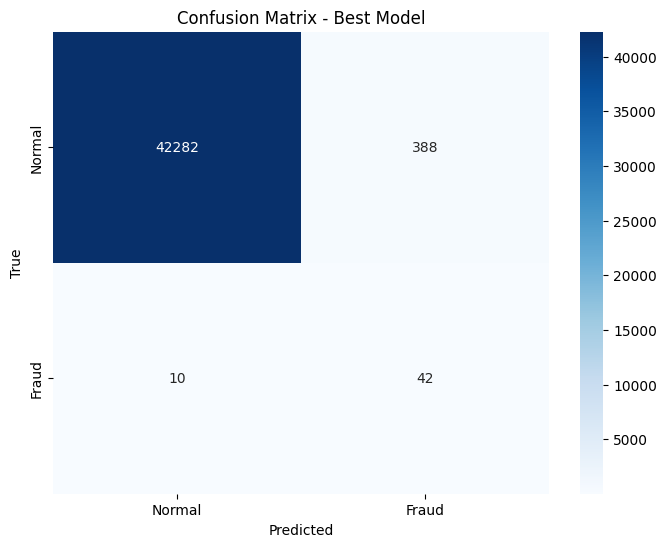

In [22]:
cm = confusion_matrix(y_te, y_pred)

print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Best Model')
plt.show()


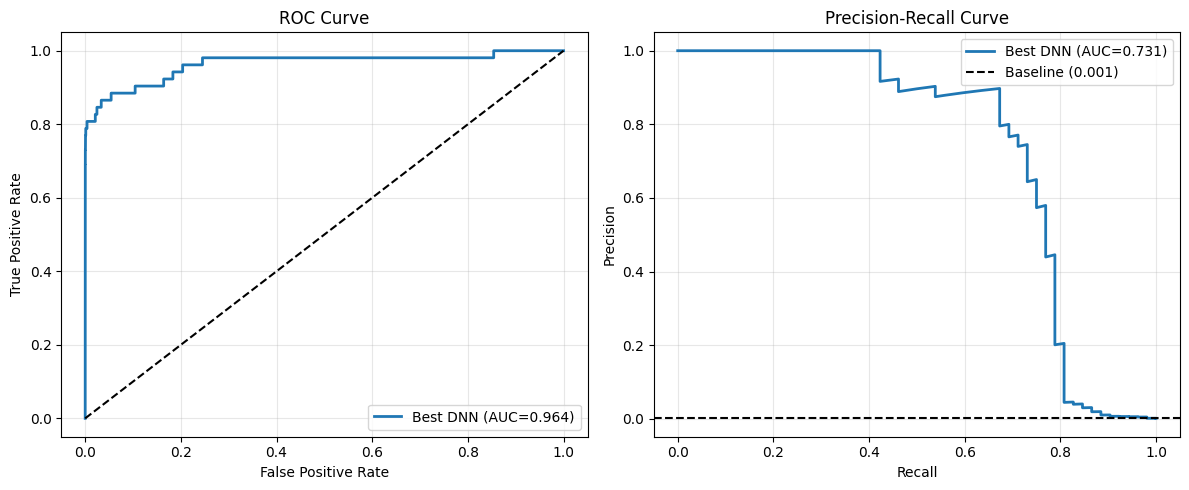

In [23]:
fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
roc_auc = roc_auc_score(y_te, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_te, y_pred_proba)
pr_auc = average_precision_score(y_te, y_pred_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Best DNN (AUC={roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Best DNN (AUC={pr_auc:.3f})', linewidth=2)
baseline = y_te.mean()
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
